In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from bs4 import BeautifulSoup, SoupStrainer
import requests
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.colors as colors
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import textwrap


drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [22]:
data=pd.read_csv("/content/drive/My Drive/IMT Atlantique 2A/Colab Notebooks/chicago_crashes_cleaned_{}.csv", sep=",")
csv = pd.read_csv('/content/drive/MyDrive/IMT Atlantique 2A/Colab Notebooks/Traffic_Crashes_-_Crashes Chicago.csv')
tabl=pd.read_csv("/content/drive/My Drive/IMT Atlantique 2A/Colab Notebooks/chicago_crashes_cleaned_32.csv", sep=",")
#removing conditions like 'unkown' and those which do not occur in large number
data_vis=csv
data_vis = data_vis.loc[data_vis['WEATHER_CONDITION']\
                        .isin(['CLEAR', 'RAIN', 'CLOUDY/OVERCAST', 'SNOW'])]
data_vis = data_vis.loc[~data_vis['LIGHTING_CONDITION']\
                        .isin(['UNKNOWN'])]
data_vis = data_vis.loc[data_vis['ROADWAY_SURFACE_COND']\
                        .isin(['DRY', 'WET', 'SNOW OR SLUSH'])]

data_vis = data_vis.loc[data_vis['INJURIES_TOTAL']\
                        .isin(['0.0', '1.0', '2.0', '3.0'])]

data_vis = data_vis.loc[data_vis['INJURIES_FATAL']\
                        .isin(['1.0', '2.0', '3.0'])]
tabl['grid'].replace('', np.nan, inplace=True)
tabl.dropna(axis=0, subset=['grid'], inplace=True)
lst = tabl['grid'].tolist()
lst = [i.replace('(','').replace(')','').split(sep=',') for i in lst]
lst = [[float(i[0]), float(i[1])] for i in lst]
lst = np.array(lst)
tabl['x']= lst[:,0]
tabl['y']= lst[:,1]

# *Analyse statistique*


## 1. Etude de la qualité des données

Une partie des colonnes du dataset sont inutilisables car elles sont majoritairement vides (colonne disant si l'accident vient de l'ouverture de la porte de la voiture, colonne indiquant si l'accident a eu lieu dans une zone en chantier,...) donc nous avons du les retirer. Une autre partie des colonnes n'est pas intéressante pour notre étude (existence de photos de l'accident, colonnes relatives au travail policier autour de l'accident,...).


Sur les 49 colonnes originelles, nous avons donc décidé de garder seulement 25 colonnes.

In [ ]:
csv.columns

Index(['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LA

Les colonnes inutiles

In [ ]:
csv = csv.drop(['CRASH_RECORD_ID','RD_NO','CRASH_DATE_EST_I','BEAT_OF_OCCURRENCE','NOT_RIGHT_OF_WAY_I',
              'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','REPORT_TYPE','HIT_AND_RUN_I','DATE_POLICE_NOTIFIED','STREET_NO','STREET_DIRECTION','STREET_NAME'],axis=1)

Une grande partie des colonnes restantes possèdent toujours des cases sans valeur définie

In [ ]:
print('{}%  des colonnes contiennent des NaN'.format(round(sum(csv.isna().any())/len(csv.columns)*100,2)))
csv.isna().any()

47.22%  des colonnes contiennent des NaN


CRASH_DATE                       False
POSTED_SPEED_LIMIT               False
TRAFFIC_CONTROL_DEVICE           False
DEVICE_CONDITION                 False
WEATHER_CONDITION                False
LIGHTING_CONDITION               False
FIRST_CRASH_TYPE                 False
TRAFFICWAY_TYPE                  False
LANE_CNT                          True
ALIGNMENT                        False
ROADWAY_SURFACE_COND             False
ROAD_DEFECT                      False
CRASH_TYPE                       False
INTERSECTION_RELATED_I            True
DAMAGE                           False
PRIM_CONTRIBUTORY_CAUSE          False
SEC_CONTRIBUTORY_CAUSE           False
DOORING_I                         True
WORK_ZONE_I                       True
WORK_ZONE_TYPE                    True
WORKERS_PRESENT_I                 True
NUM_UNITS                        False
MOST_SEVERE_INJURY                True
INJURIES_TOTAL                    True
INJURIES_FATAL                    True
INJURIES_INCAPACITATING  

On retire les colonnes possédant trop de Nan pour être exploitables.

In [ ]:

print("Présence de Nan dans LANE_CNT {}%".format(sum(csv['LANE_CNT'].isna())/len(csv) *100))
csv = csv.drop(['LANE_CNT'],axis=1)

print('Présence de Nan dans DOORING_I {}%'.format(csv['DOORING_I'].isna().sum()/len(csv)*100))
csv = csv.drop(['DOORING_I'],axis=1)

print('Présence de NaN dans WORK_ZONE_I {}%'.format(csv['WORK_ZONE_I'].isna().sum()/len(csv)*100))
csv = csv.drop('WORK_ZONE_I',axis=1)
csv = csv.drop(['WORK_ZONE_TYPE','WORKERS_PRESENT_I'],axis=1) #ces deux colonnes sont liées a la précédente

Présence de Nan dans LANE_CNT 55.576444740167815%
Présence de Nan dans DOORING_I 99.66731120469069%
Présence de NaN dans WORK_ZONE_I 99.3352922525934%


Les colonnes relatives aux blessures paraissent reliées à celle sur les dégats en dollars

In [ ]:
print('Over $1500:\n',(csv['INJURIES_TOTAL'][csv['DAMAGE']=='OVER $1,500']).value_counts())
print('entre $501 - $1500:\n',(csv['INJURIES_TOTAL'][csv['DAMAGE']=='$501 - $1,500']).value_counts())
print('$500 OR LESS:\n',(csv['INJURIES_TOTAL'][csv['DAMAGE']=='$501 - $1,500']).value_counts())


csv = csv.drop(csv.iloc[((np.where(csv['INJURIES_TOTAL'].isna().values==True)))].index)

Over $1500:
 0.0     216634
1.0      27612
2.0       7681
3.0       2525
4.0        922
5.0        341
6.0        140
7.0         54
8.0         18
9.0         14
10.0         8
15.0         4
11.0         3
13.0         2
21.0         2
12.0         2
16.0         1
19.0         1
Name: INJURIES_TOTAL, dtype: int64
entre $501 - $1500:
 0.0     124467
1.0       6563
2.0       1017
3.0        253
4.0         75
5.0         33
6.0         11
7.0          2
11.0         2
15.0         1
10.0         1
Name: INJURIES_TOTAL, dtype: int64
$500 OR LESS:
 0.0     124467
1.0       6563
2.0       1017
3.0        253
4.0         75
5.0         33
6.0         11
7.0          2
11.0         2
15.0         1
10.0         1
Name: INJURIES_TOTAL, dtype: int64


En regardant ces colonnes, on s'apercoit que 'damage' et 'injuries_total' ne sont pas corrélées donc nous retirons 'injuries_total'.


Le tableau final ne possède plus de Nan et ressemble à ceci : 

In [ ]:
csv.head()

,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,INTERSECTION_RELATED_I,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,10/02/2018 06:30:00 PM,10,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,OTHER,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",NOT APPLICABLE,NOT APPLICABLE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,18,3,10,NaN,NaN,NaN
1,06/27/2019 04:00:00 PM,45,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,NaN,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,16,5,6,NaN,NaN,NaN
2,02/13/2020 04:30:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,ONE-WAY,STRAIGHT AND LEVEL,WET,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,NaN,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,2,"REPORTED, NOT EVIDENT",1.0,0.0,0.0,0.0,1.0,2.0,0.0,16,5,2,NaN,NaN,NaN
3,06/30/2017 04:00:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,Y,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,16,6,6,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
4,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,"OVER $1,500",UNABLE TO DETERMINE,UNABLE TO DETERMINE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,22,5,3,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)


Les données contiennent toues les accidents et leurs caractéristiques ayant eu lieu à Chicago. En utilisant les coordonnées GPS des lieus d'accidents, nous avons créé une grille que l'on peut superposer à la carte de Chicago pour rendre l'analyse plus facile.

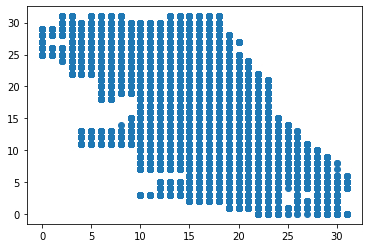

In [ ]:
plt.scatter(lst[:,0],lst[:,1])

## 2. Etude statistique


#### a) Impact des conditions extérieures sur les accidents


[Text(0, 0, 'FAILING TO YIELD RIGHT-OF-WAY'),
 Text(0, 0, 'UNABLE TO DETERMINE'),
 Text(0, 0, 'IMPROPER OVERTAKING/PASSING'),
 Text(0, 0, 'EXCEEDING SAFE SPEED FOR CONDITIONS'),
 Text(0, 0, 'IMPROPER BACKING'),
 Text(0, 0, 'DISTRACTION - FROM INSIDE VEHICLE'),
 Text(0, 0, 'IMPROPER LANE USAGE'),
 Text(0, 0, 'FOLLOWING TOO CLOSELY'),
 Text(0, 0, 'FAILING TO REDUCE SPEED TO AVOID CRASH'),
 Text(0, 0, 'DISREGARDING TRAFFIC SIGNALS'),
 Text(0, 0, 'NOT APPLICABLE'),
 Text(0, 0, 'EXCEEDING AUTHORIZED SPEED LIMIT'),
 Text(0, 0, 'IMPROPER TURNING/NO SIGNAL'),
 Text(0, 0, 'DISTRACTION - FROM OUTSIDE VEHICLE'),
 Text(0, 0, 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER'),
 Text(0, 0, 'WEATHER'),
 Text(0, 0, 'EQUIPMENT - VEHICLE CONDITION'),
 Text(0, 0, 'DISREGARDING STOP SIGN'),
 Text(0, 0, 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)'),
 Text(0, 0, 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'),
 Text(0, 0, 'DRIVING SKILLS/KNOWL

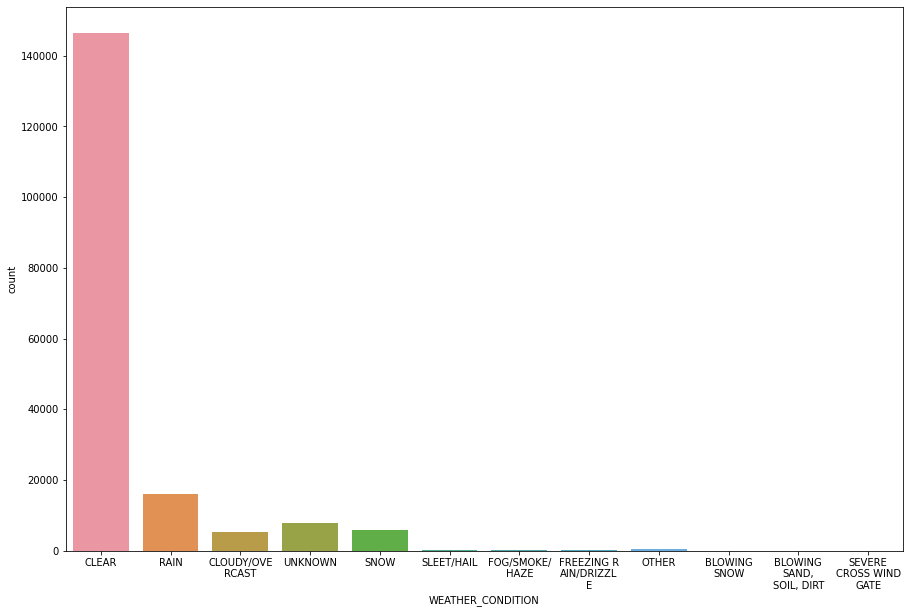

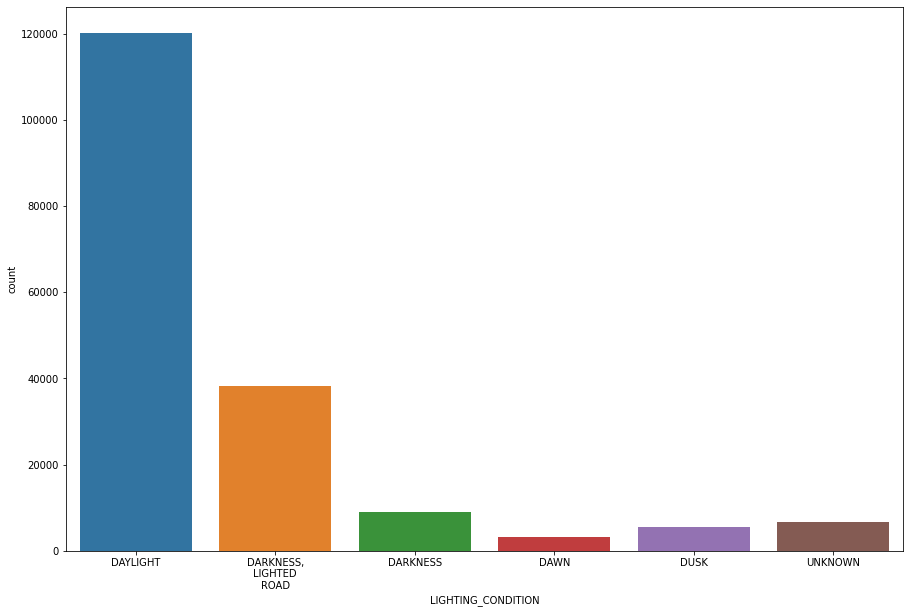

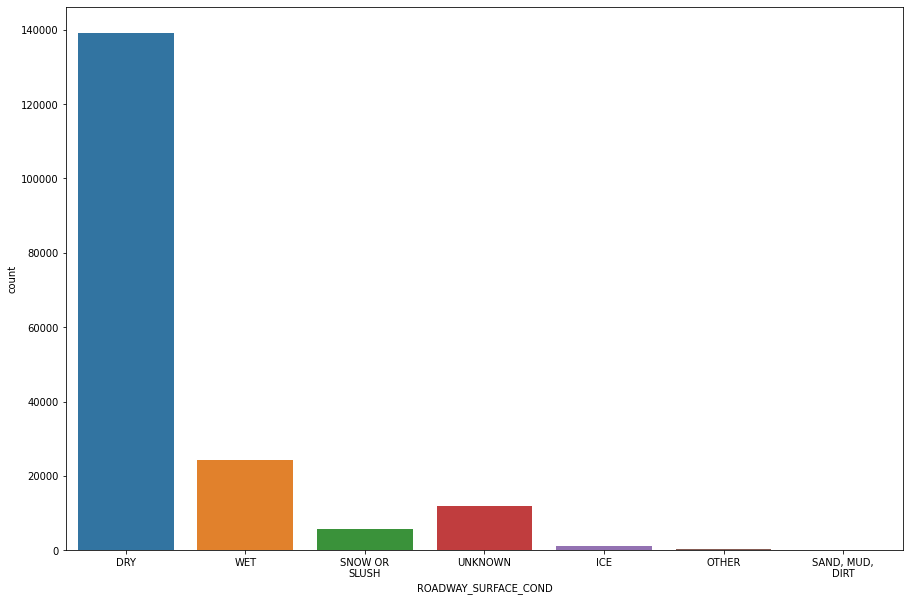

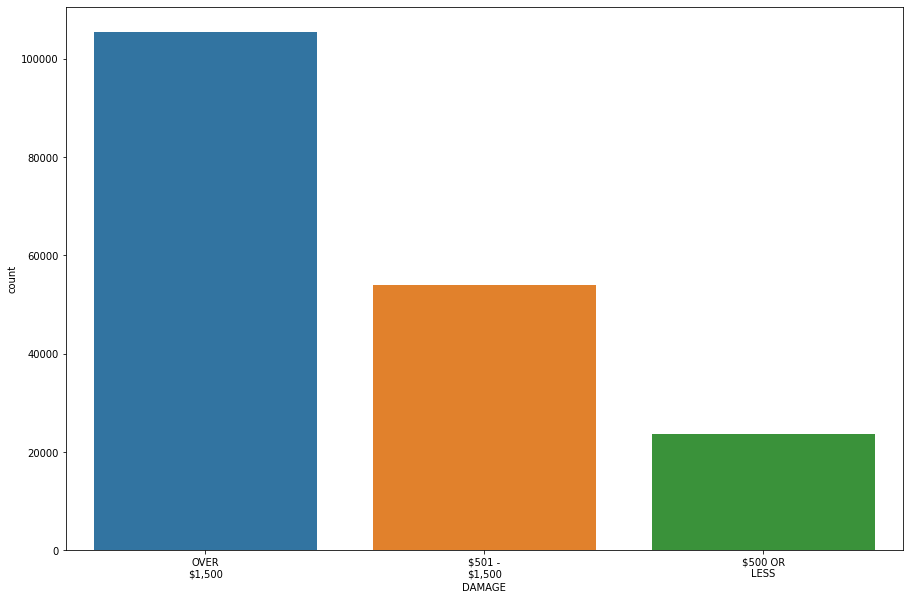

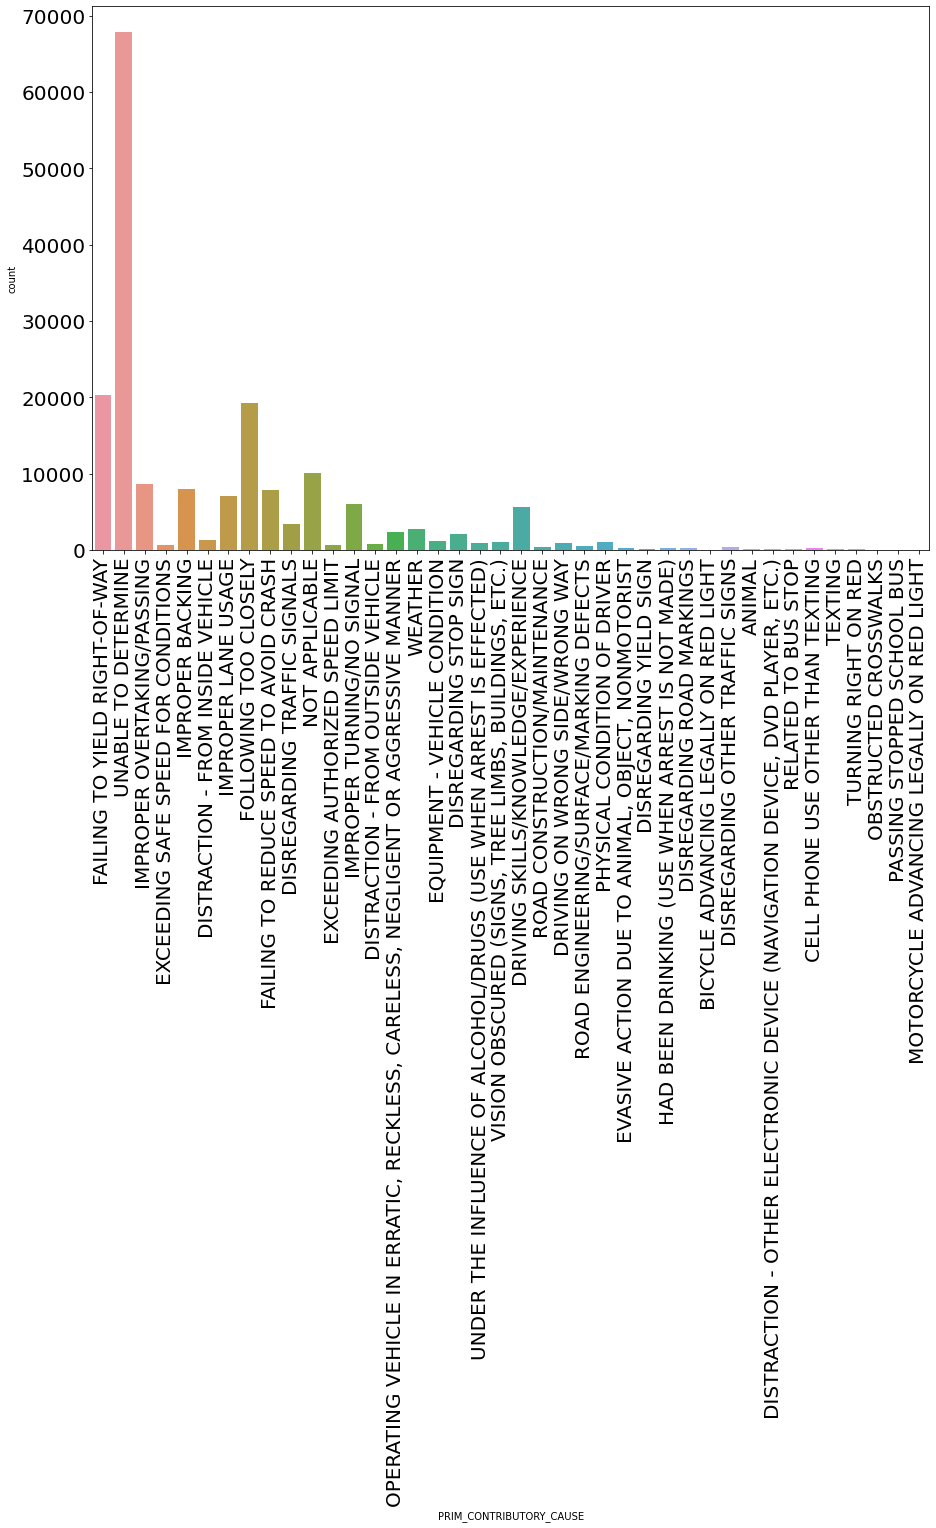

In [ ]:
max_width = 10
cols = ['WEATHER_CONDITION', 'LIGHTING_CONDITION',\
        'ROADWAY_SURFACE_COND', 'DAMAGE']
for i, col in enumerate(data[cols]):
    plt.figure(i, figsize = (15.0,10.0))
    b = sns.countplot(x=col, data=data)
    b.tick_params(labelsize=10)
    b.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in b.get_xticklabels())

plt.figure(10, figsize = (15.0,10.0))
b = sns.countplot(x=data['PRIM_CONTRIBUTORY_CAUSE'], data=data)
b.tick_params(labelsize=)
b.set_xticklabels(b.get_xticklabels(), rotation = 90)


On remarque que la grande majorité des accidents a lieu dans des conditions normales à causes d'erreur de conduite. Les erreurs d'anticipations des conducteurs liées aux conditions extérieures semblent plus rares. Le comportement humain est donc la cause la plus courante des acccidents.

In [ ]:

#On calcule le nombre d'accidents en fonction des états des dispositifs
AccByDeviceConditions = data2.groupby(['DEVICE_CONDITION']).agg('count')['CRASH_RECORD_ID'].sort_values(ascending=False)[:30].to_frame(name='totalAccidents').reset_index()
figfunc(
    x_ = AccByDeviceConditions['DEVICE_CONDITION'],
    y_ = AccByDeviceConditions['totalAccidents'],
    title_="Nombre d'accidents en fonction des états des dispositifs", 
    x_title="Device conditions", y_title="Nombre total d'accidents", 
    height_=600, width_=600)
nbrTotal = data2.groupby(['categorie_new']).agg('mean')[list_to_change[i]].sort_values(ascending=False)[:30].to_frame(name='total').reset_index()

  fig = go.Figure([go.Pie(labels=nbrTotal['categorie_new'],values=nbrTotal['total'])])

  fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=15)
  fig.update_layout(title=list_to_change[i] + " selon les catégorie de média", title_x=0.5)
  fig.show()

On voit que les défauts de signalisation ont un impact minime sur les accidents tandis que 58% d'entre eux ont lieu dans des espaces sans contrôles routiers.

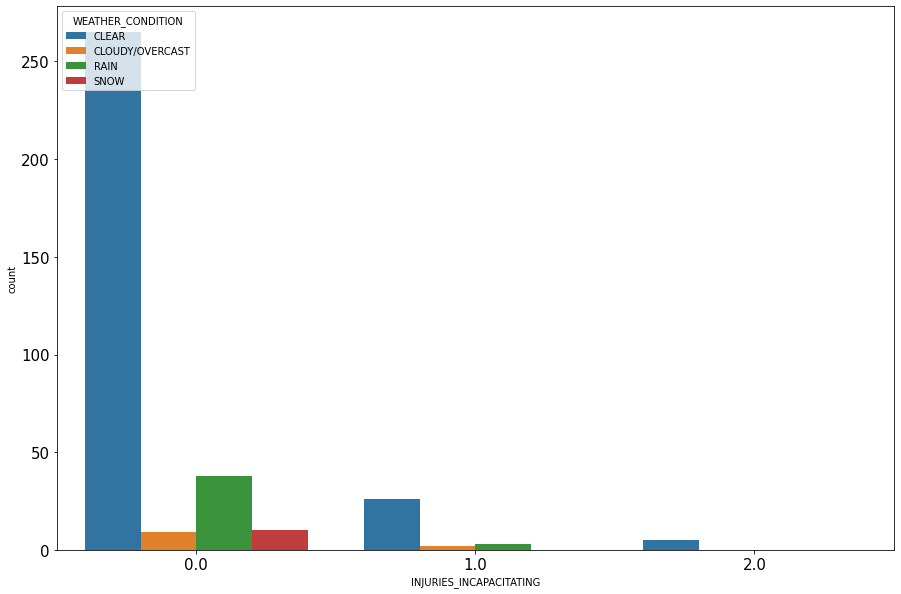

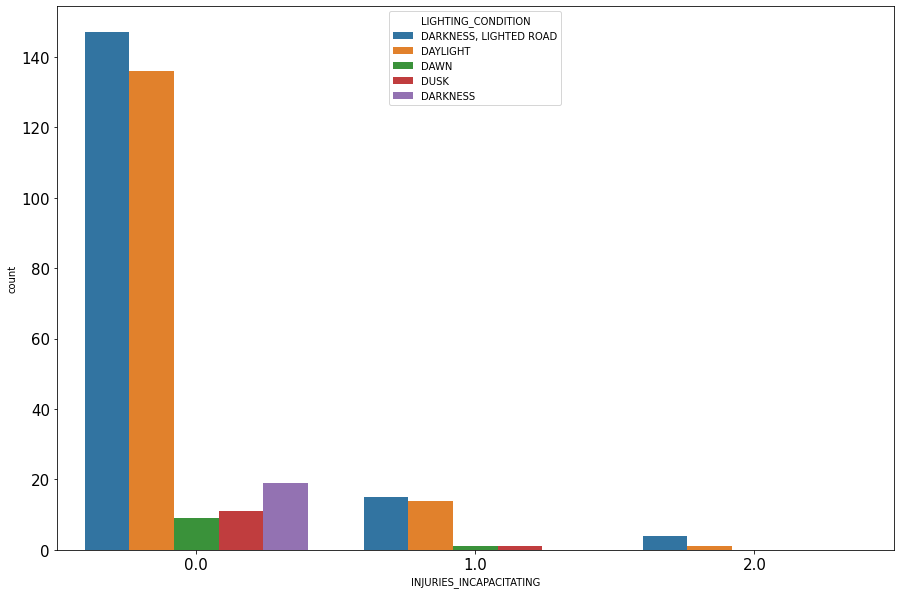

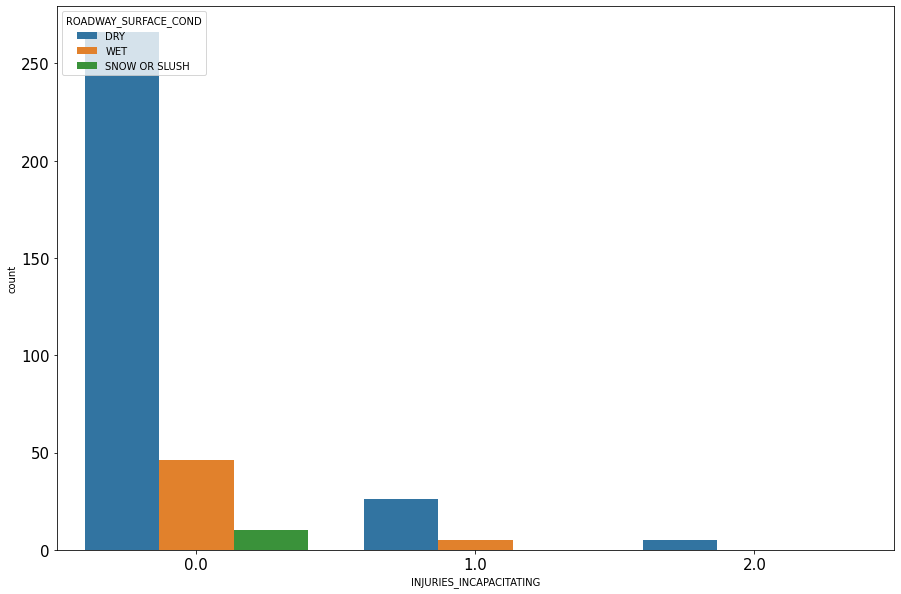

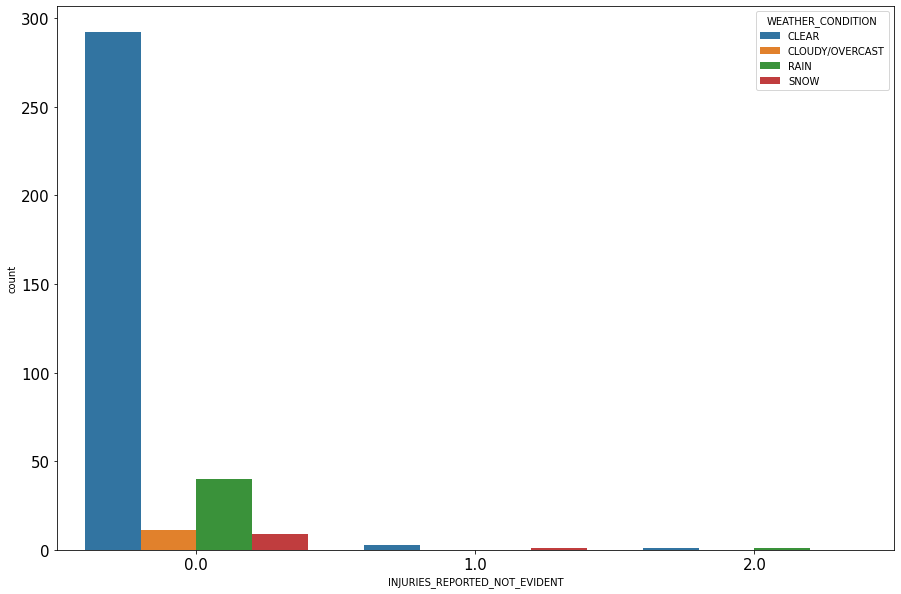

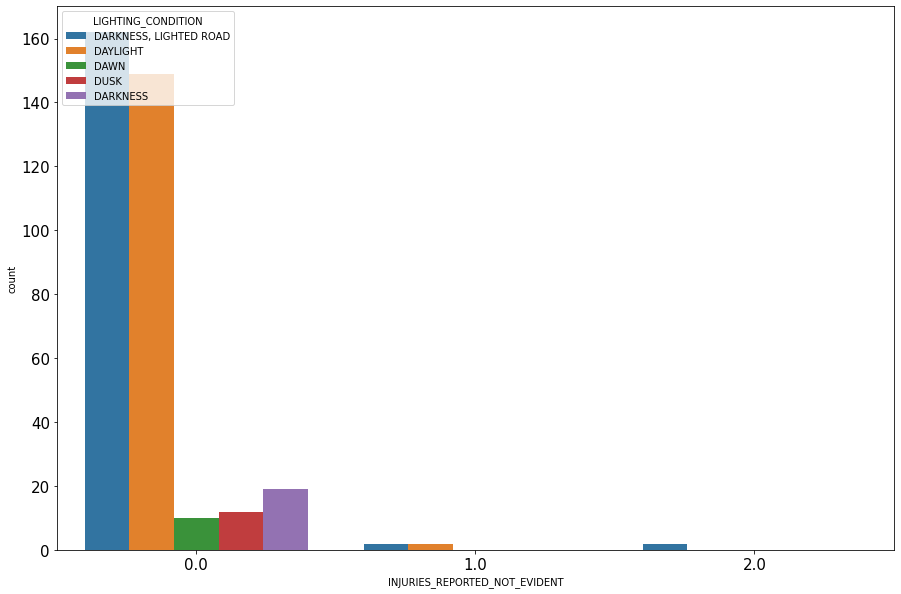

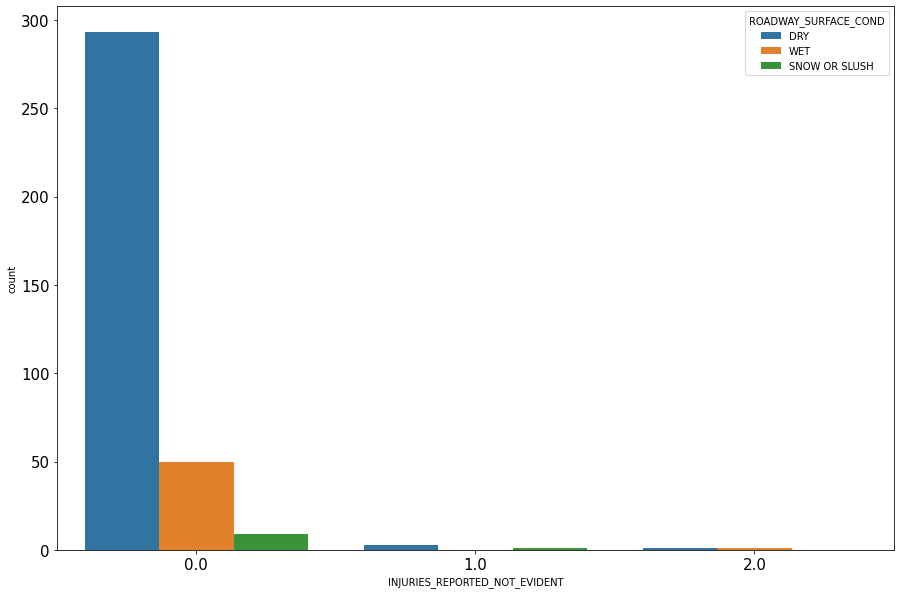

In [23]:
cols = ['INJURIES_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT']

hues = ['WEATHER_CONDITION', 'LIGHTING_CONDITION',\
        'ROADWAY_SURFACE_COND']

max_width = 10

i=0
for col in data_vis[cols]:
    for hue in data_vis[hues]:
        plt.figure(i, figsize=(15.0,10.0))
        b = sns.countplot(x=col, hue=hue, data=data_vis)
        b.tick_params(labelsize=15)
        b.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in b.get_xticklabels())
        i+=1

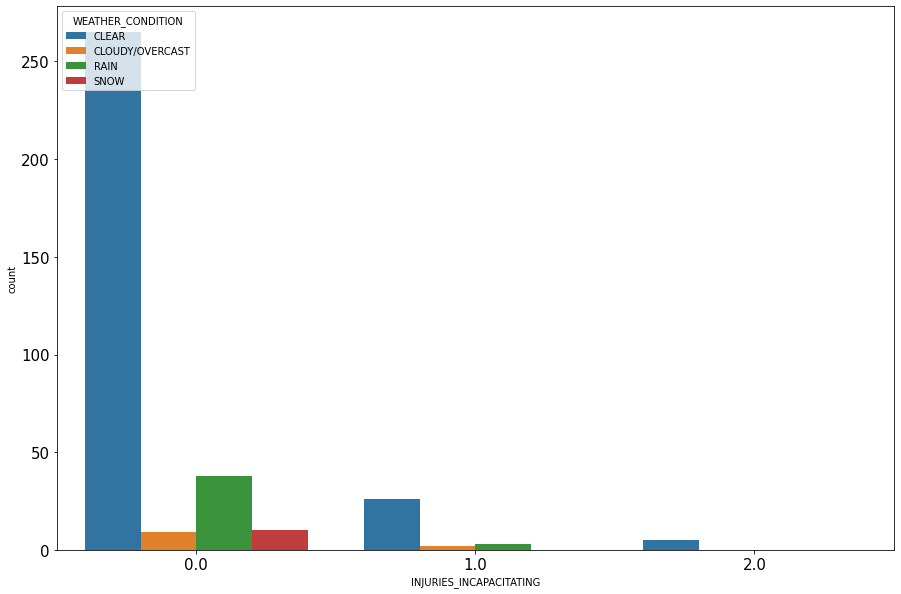

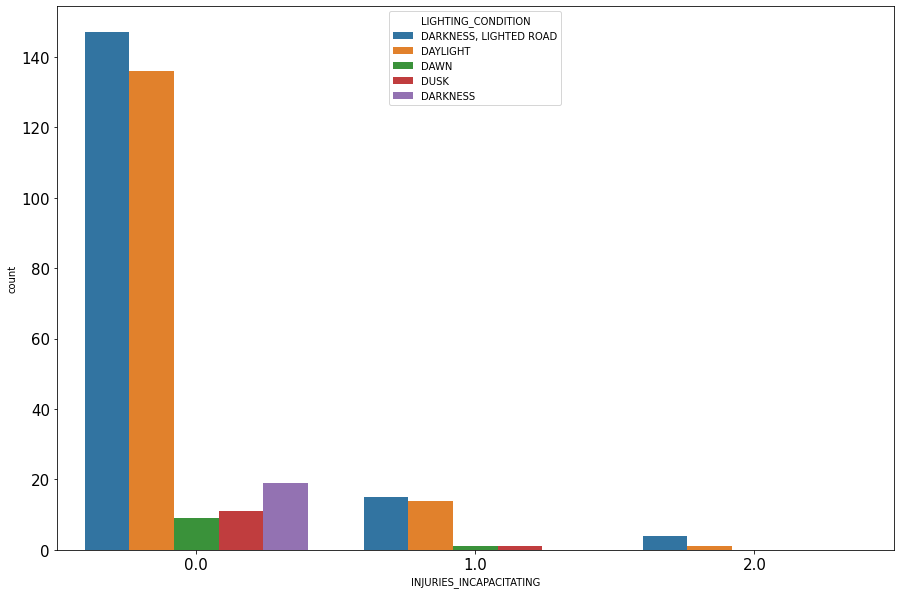

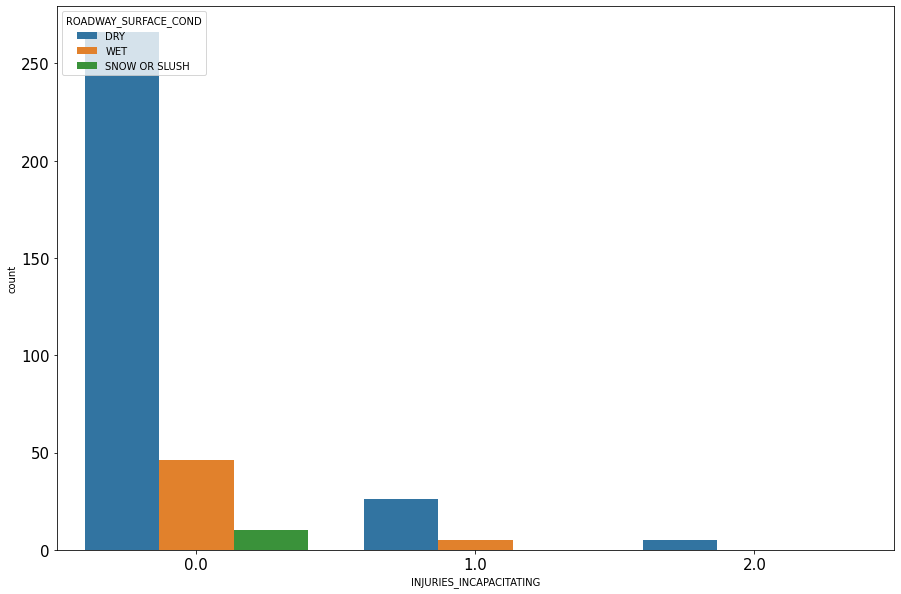

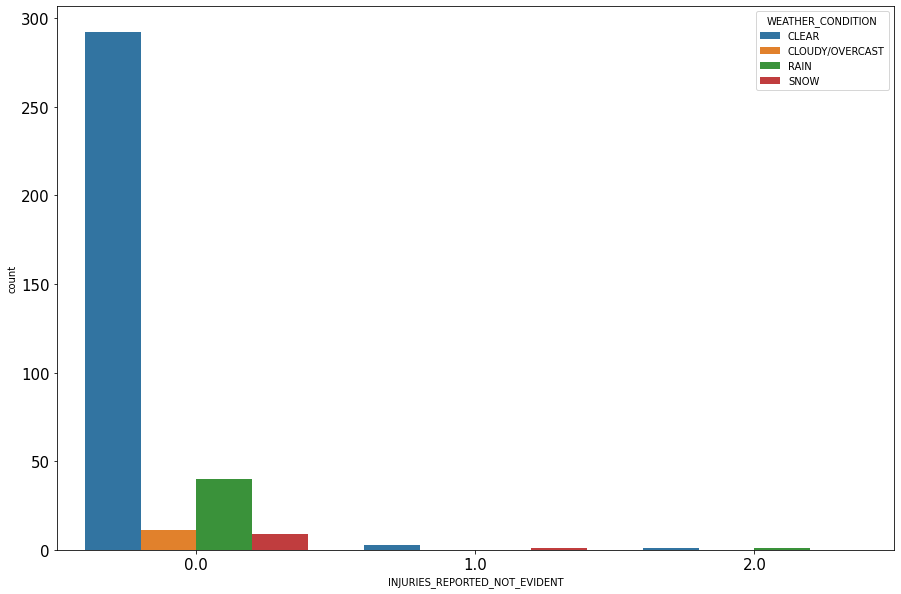

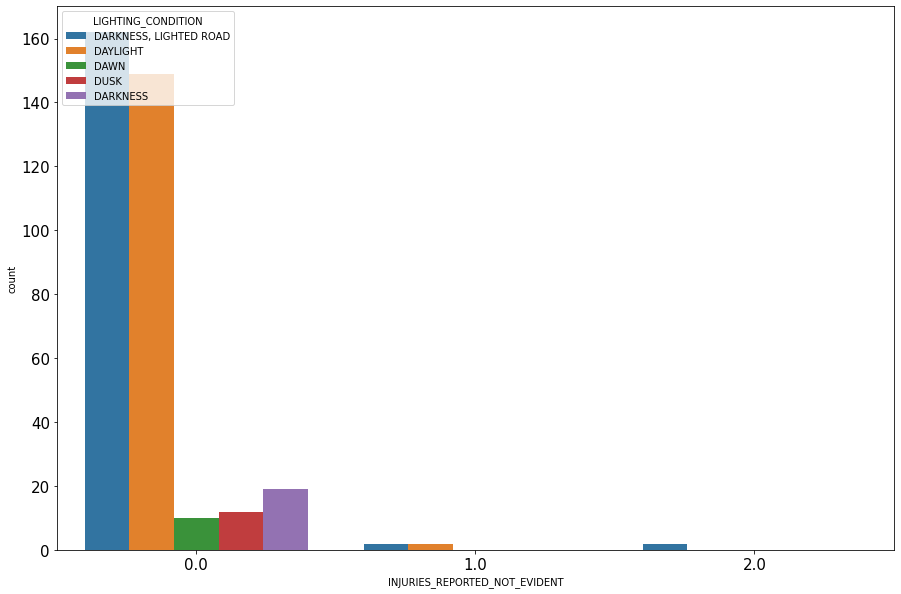

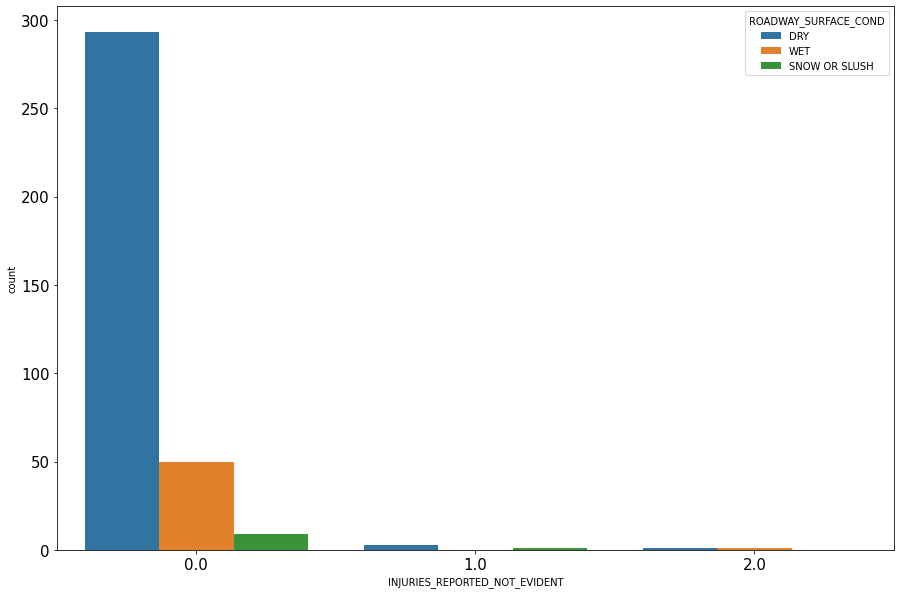

In [24]:
cols = ['INJURIES_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT']

hues = ['WEATHER_CONDITION', 'LIGHTING_CONDITION',\
        'ROADWAY_SURFACE_COND']

max_width = 10

i=0
for col in data_vis[cols]:
    for hue in data_vis[hues]:
        plt.figure(i, figsize=(15.0,10.0))
        b = sns.countplot(x=col, hue=hue, data=data_vis)
        b.tick_params(labelsize=15)
        b.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in b.get_xticklabels())
        i+=1

Même si les conditions extérieures augmentent peu le nombre d'accidents, elle ont un impact considéreable sur la gravité des accidents. En effet, les accidents dans l'obscurité ou sur les routes humides causent souvent plus de victimes et provoquent des blessures plus graves.

#### b) Variations temporelles des accidents

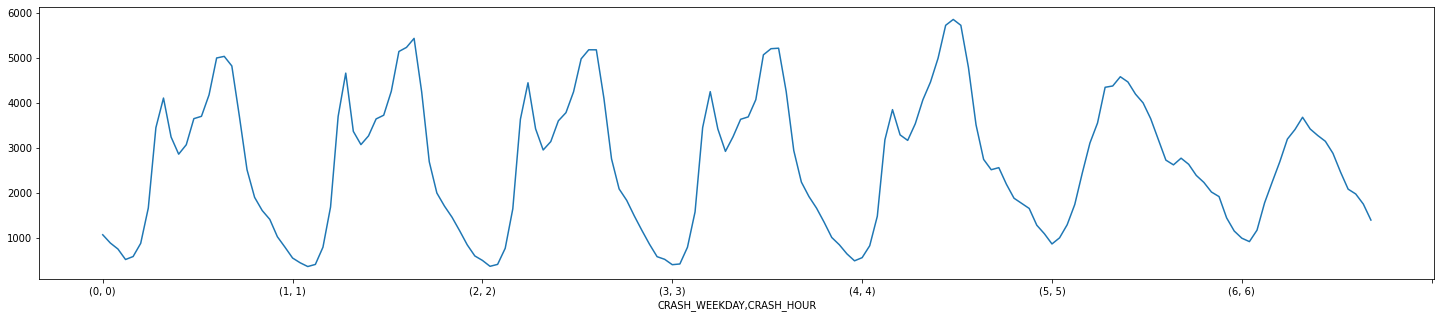

In [ ]:
tabl['compte']=1
tabl.groupby(['CRASH_WEEKDAY', 'CRASH_HOUR']).count().compte.plot(figsize=(25,5))


Nous avons tracé la courbe du nombre d'accidents par heures sur une durée d'une semaine. 

Nous retrouvons bien les départs au travail entre 7 et 9h qui correspondent à un pic d'accident. Il y a un deuxième pic de 14 à 16h, ce qui correspond au retour du travail et aux déplacements liés aux activités des habitants de Chicago. 

Le week-end, l'unique pic d'accident se situe vers le milieu de la journée car la plupart des habitants ne se déplacent pas le matin. 

Il y a une légère hausse des accidents les vendredi et samedi soir, ce qui peut être expliqué par les individus allant et rentrant en soirée. 

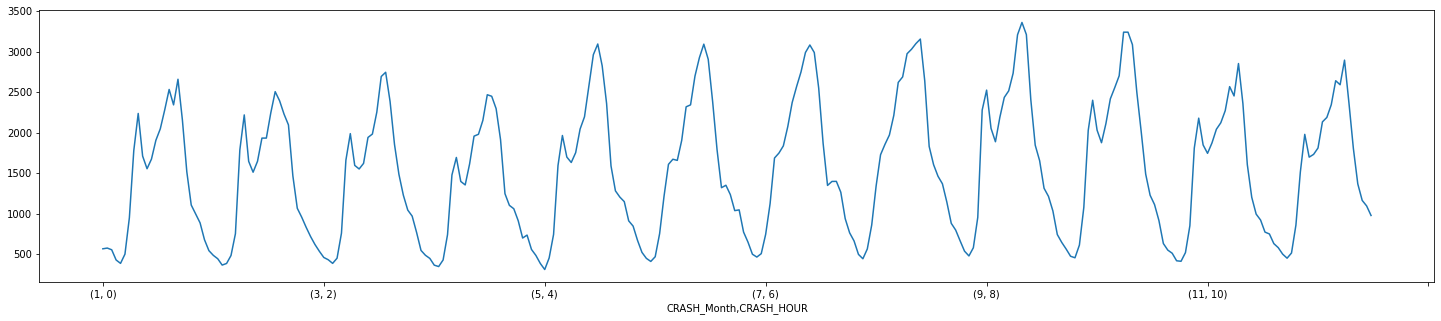

In [ ]:
tabl['compte']=1
tabl.groupby(['CRASH_Month', 'CRASH_HOUR']).count().compte.plot(figsize=(25,5))

Ici, nous avons affiché le nombre d'accidents par heures de la journée pour chaques mois de l'année. La logique trouvée sur les jours de la semaine se retrouve sur l'année. En juin, juillet et août, les américains partent en vacances donc le nombre d'accidents augmentent au cours de la journée jusqu'à 15h, puis redescent en même temps que l'activité de la ville diminue. Durant les autres mois, un nombre beaucoup plus grand de personnes vont travailler chaques jours donc on observe bien des pics d'accidents que l'on peut associer aux départs. Le pic de l'après-midi est légèrements décallé vers une horaire plus tardive car les employés rentrent du travail de 15h à 18h.

De manière plus globale, nous observons qu'il y a plus d'accidents durant les mois les plus ensoleillés, peut-être car les habitants de Chicago préfèrent sortir quand il y a encore du soleil.

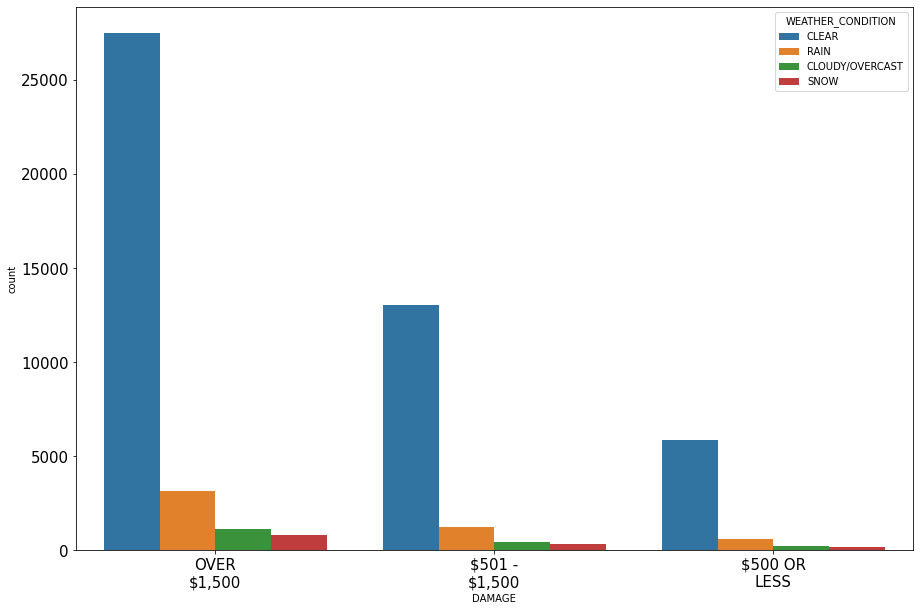

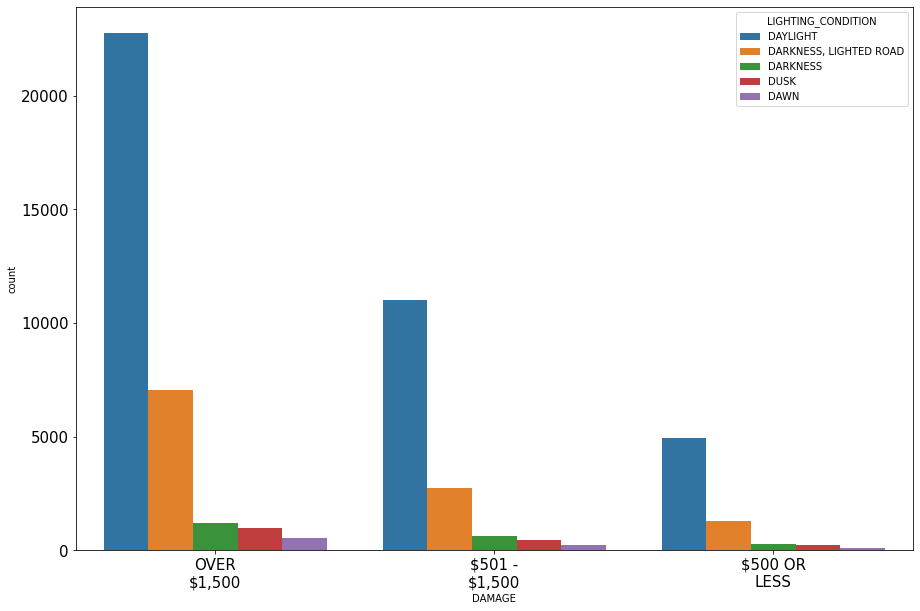

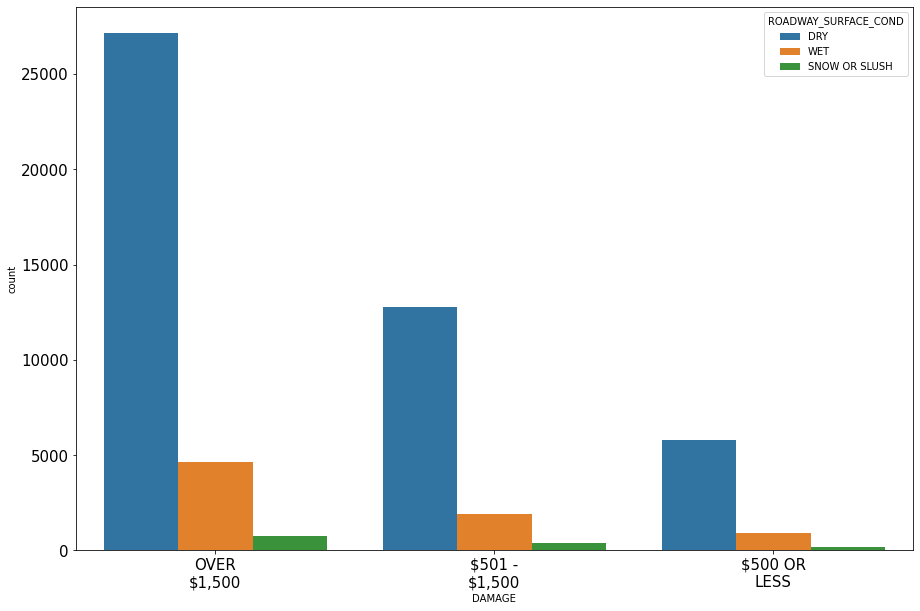

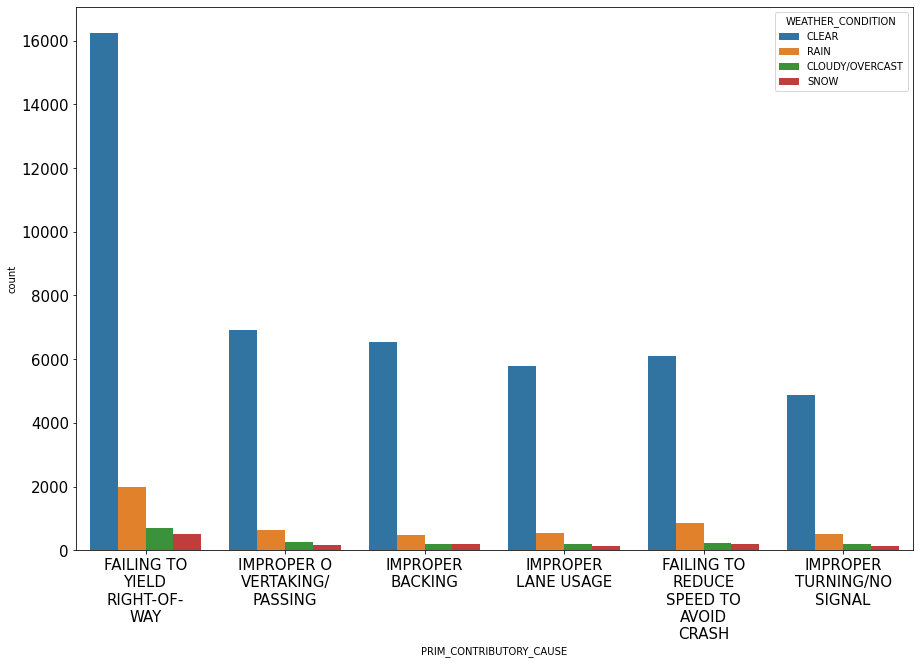

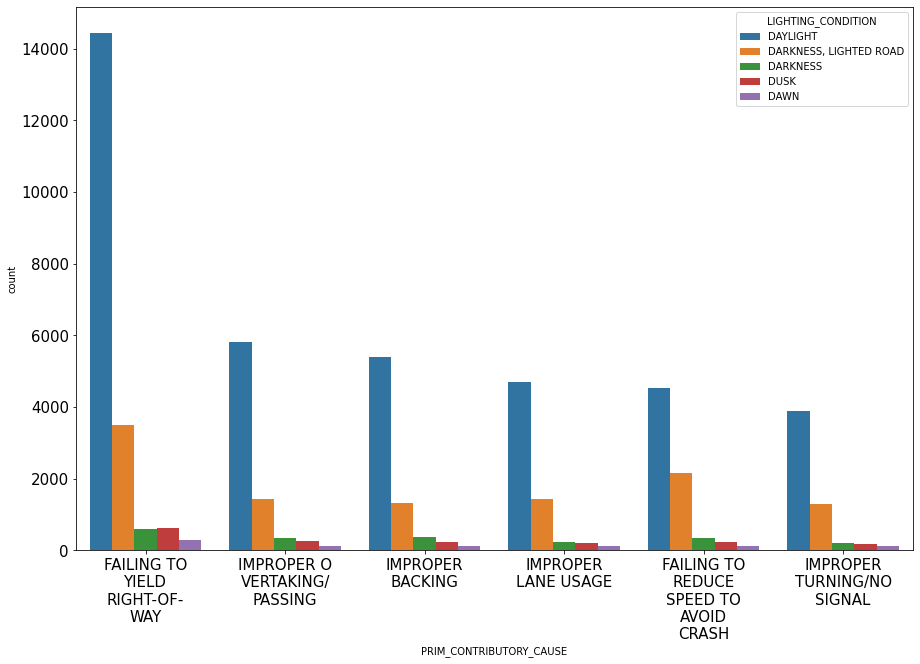

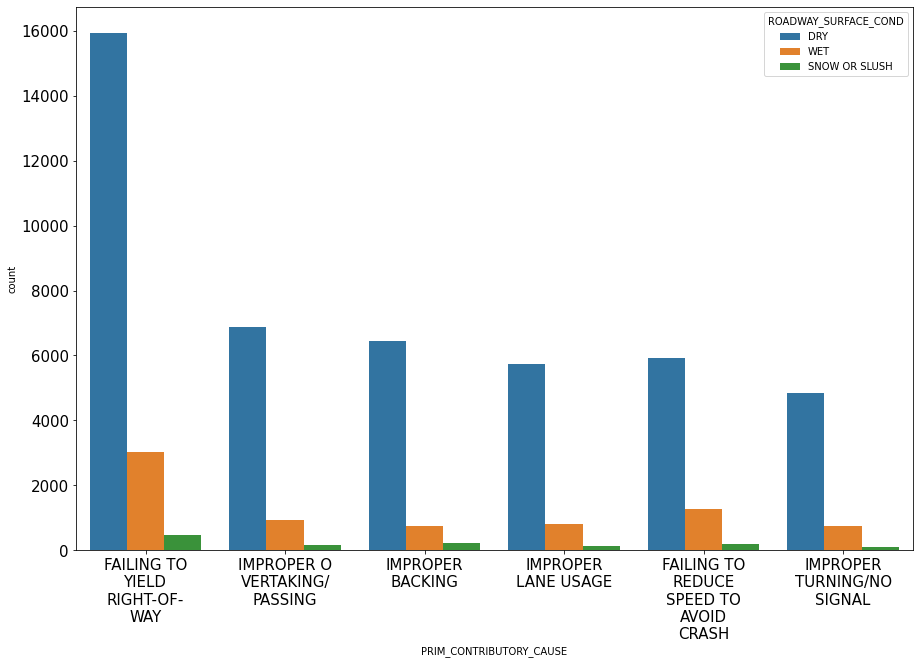

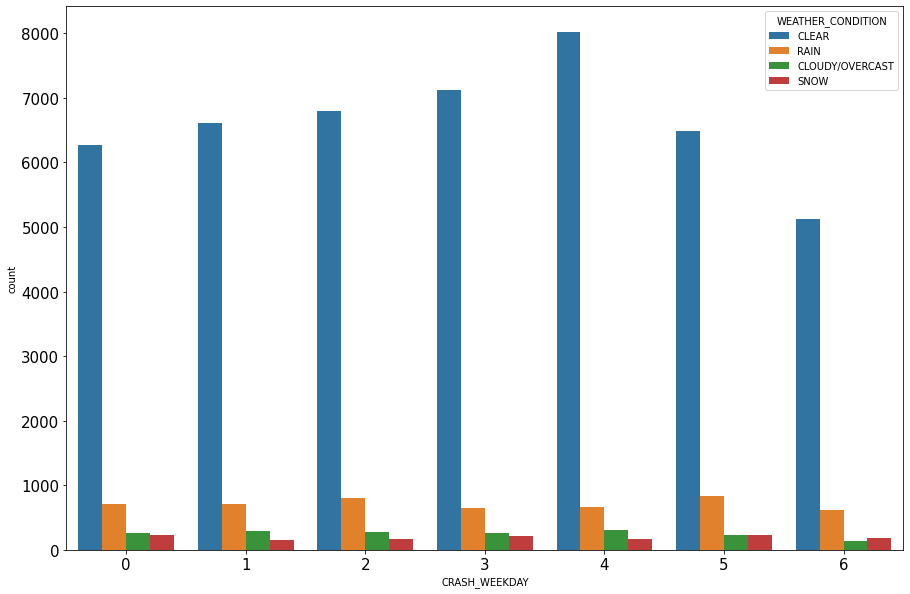

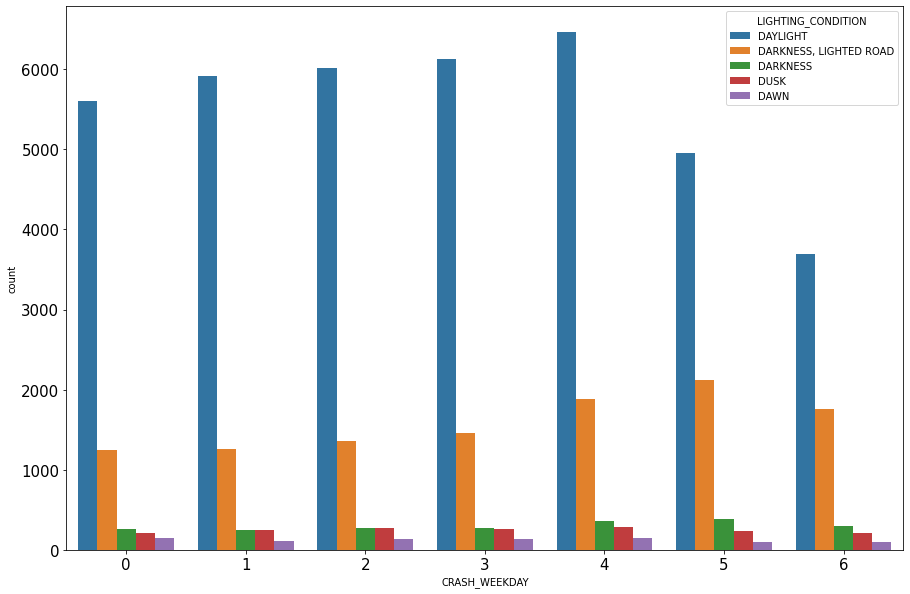

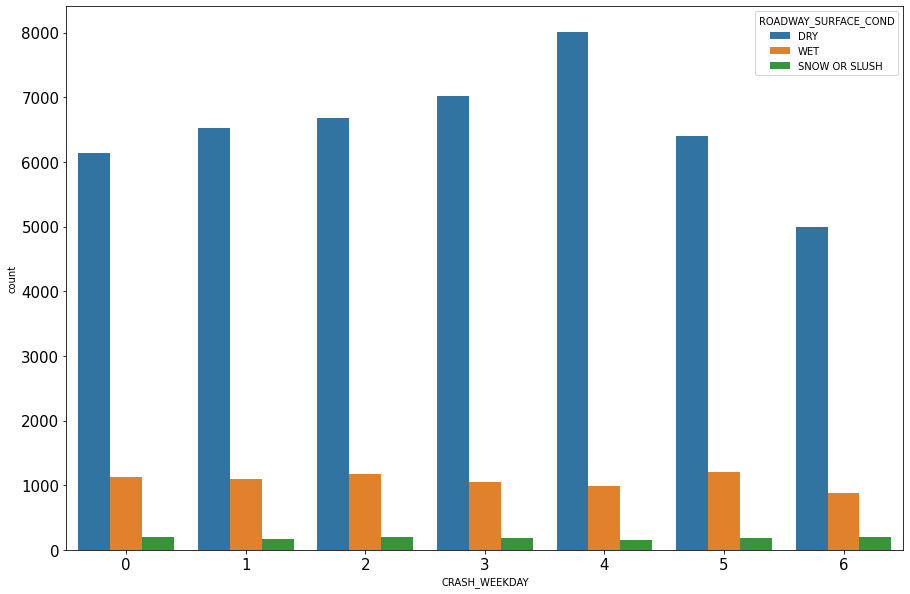

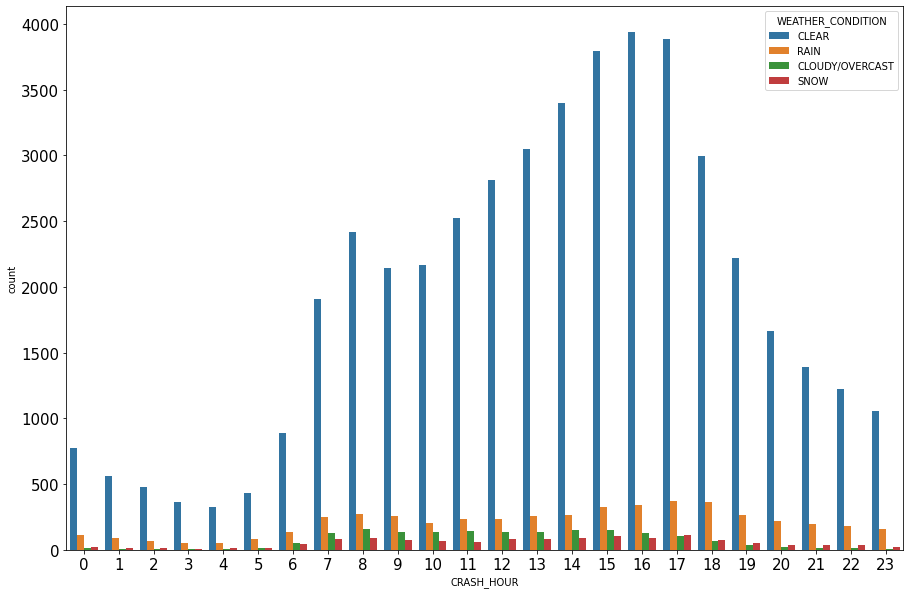

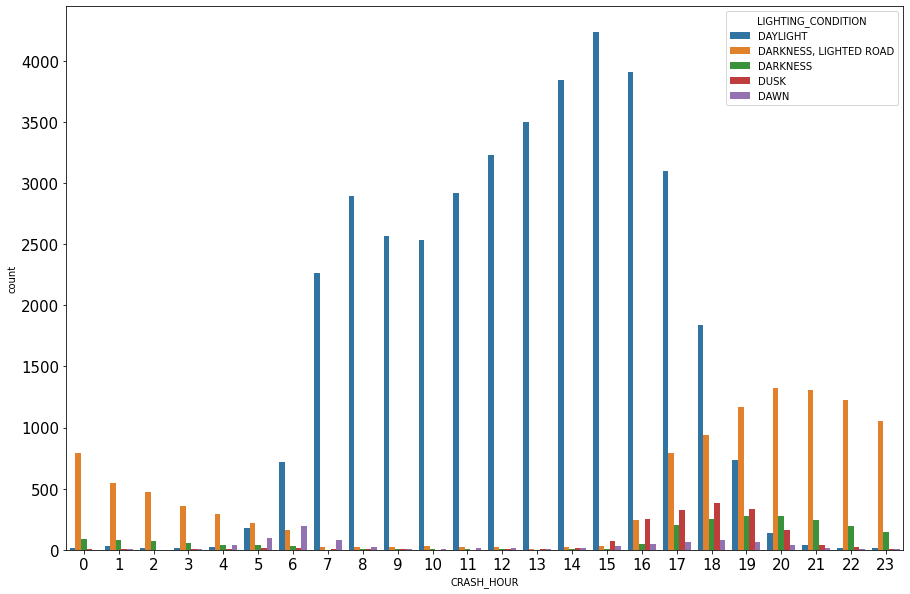

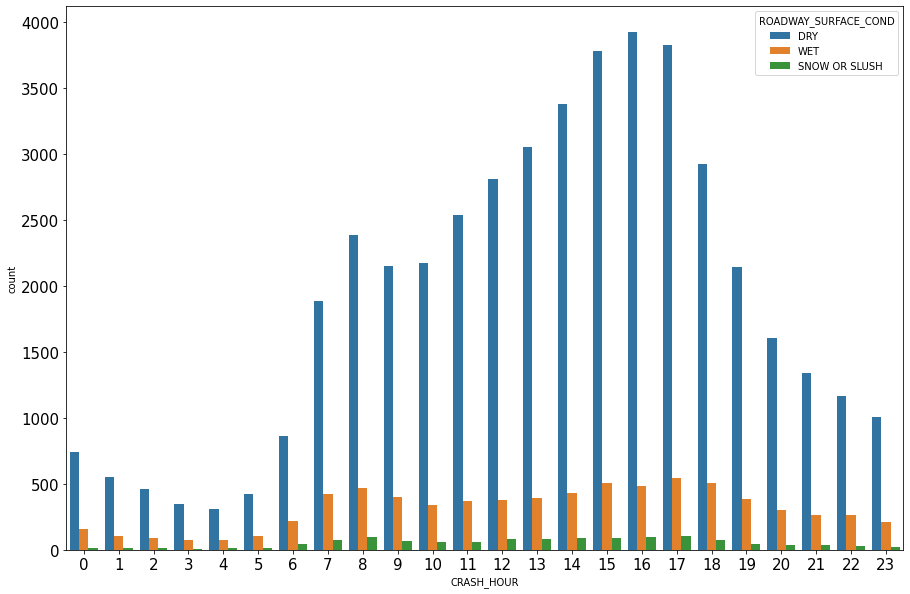

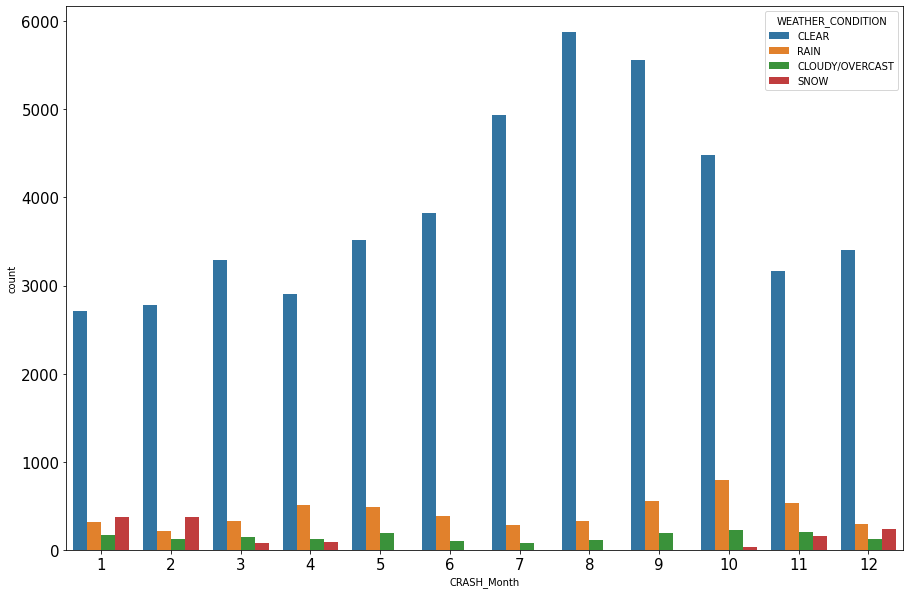

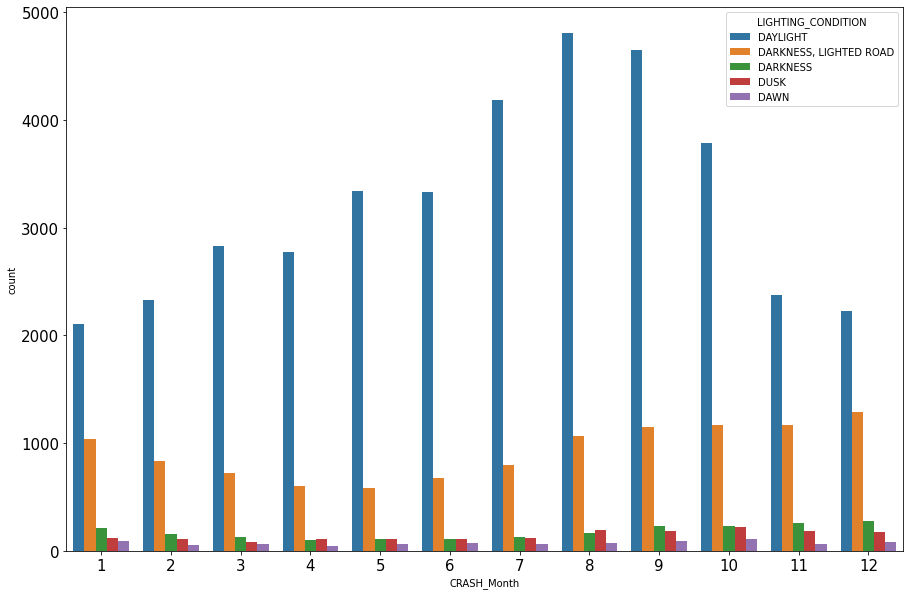

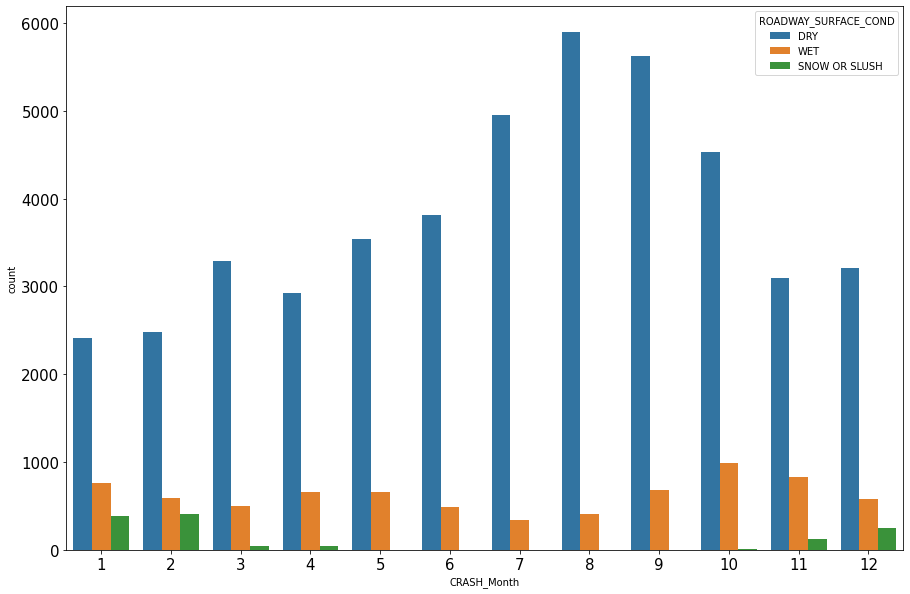

In [20]:
data_vis=data
data_vis = data_vis.loc[data_vis['WEATHER_CONDITION']\
                        .isin(['CLEAR', 'RAIN', 'CLOUDY/OVERCAST', 'SNOW'])]
data_vis = data_vis.loc[~data_vis['LIGHTING_CONDITION']\
                        .isin(['UNKNOWN'])]
data_vis = data_vis.loc[data_vis['ROADWAY_SURFACE_COND']\
                        .isin(['DRY', 'WET', 'SNOW OR SLUSH'])]
data_vis = data_vis.loc[data_vis['PRIM_CONTRIBUTORY_CAUSE']\
                        .isin(['FAILING TO YIELD RIGHT-OF-WAY',\
                               'IMPROPER OVERTAKING/PASSING',\
                              'IMPROPER BACKING', \
                              'IMPROPER LANE USAGE',\
                              'FOLLOWING TO CLOSELY',\
                              'FAILING TO REDUCE SPEED TO AVOID CRASH',\
                              'IMPROPER TURNING/NO SIGNAL',\
                              'DRIVING SKILLS/KONWLEDGE/EXPERIENCE'])]
                              
cols = ['DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',\
       'CRASH_WEEKDAY', 'CRASH_HOUR', 'CRASH_Month']

hues = ['WEATHER_CONDITION', 'LIGHTING_CONDITION',\
        'ROADWAY_SURFACE_COND']

max_width = 10

i=0
for col in data_vis[cols]:
    for hue in data_vis[hues]:
        plt.figure(i, figsize=(15.0,10.0))
        b = sns.countplot(x=col, hue=hue, data=data_vis)
        b.tick_params(labelsize=15)
        b.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in b.get_xticklabels())
        i+=1

Nous ponvons observer sur ces courbes l'influence des saisons sur les accidents, avec l'apparition de la neige l'hiver, et la réduction des pluies l'été. Il faut remarquer que même sir le traffic nocturne représente 10% du traffic journalier, plus de 25% des accidents se déroulent la nuit. 

#### c) Variations spatiales des accidents

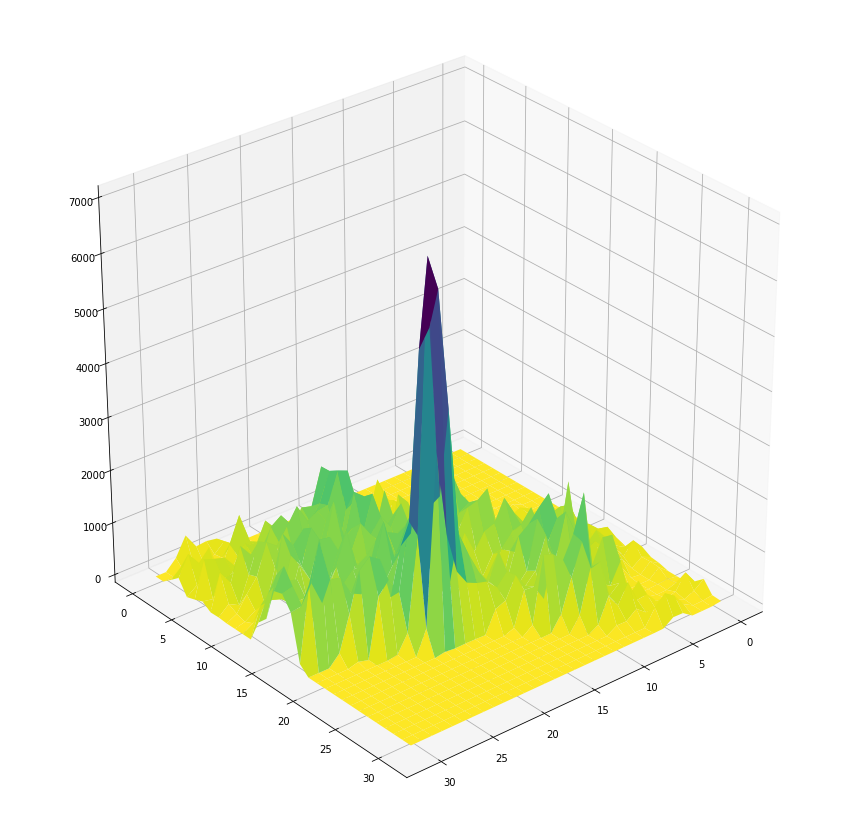

In [ ]:
tabl['compte']=1
test = tabl.groupby(['x','y']).count().compte
test = test.unstack()
test = test.fillna(0)
x = [i for i in range(32)]
y = [i for i in range(32)]

pos = np.zeros((32,32))


for i in x:
  for j in y:
    pos[j,i]=test[i][j]

x,y=np.meshgrid(x,y)

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, pos, cmap=cm.viridis_r)
ax.view_init(elev=30, azim=50)

Nous pouvons voir immédiatement que la répartition des accidents sur Chicago n'est pas uniforme. Certaines cases de notre grille concentrent beaucoup plus d'accidents que les autres. La case médiane contient 0.15% des accidents tandis que la case la plus accidentée en contient 1.5%.

Il y a donc des zones beaucoup plus dangereuses en voiture. Pourtant les routes les plus dangereuses ne sont pas dans les zones les plus dangereuses. 

In [ ]:
(tabl.groupby(['x','y']).count().compte/442645).describe()

count    583.000000
mean       0.001715
std        0.001632
min        0.000002
25%        0.000619
50%        0.001410
75%        0.002499
max        0.015952
Name: compte, dtype: float64

In [ ]:
streetDanger = tabl[tabl['grid']== '(21.0, 21.0)'].STREET_NAME.unique()
print(tabl.STREET_NAME.value_counts())
tabl[tabl['STREET_NAME'].isin(streetDanger)].STREET_NAME.value_counts()

WESTERN AVE    12052
PULASKI RD     10675
CICERO AVE      9756
ASHLAND AVE     9601
HALSTED ST      8564
               ...  
119TH PL           1
KEDVALE            1
DRAPER ST          1
OGDEN              1
STONE ST           1
Name: STREET_NAME, Length: 1496, dtype: int64


MICHIGAN AVE             6070
STATE ST                 5398
CLARK ST                 5077
GRAND AVE                4642
CHICAGO AVE              4020
WABASH AVE               2003
OHIO ST                  1328
ONTARIO ST               1319
DEARBORN ST              1280
HURON ST                  772
ERIE ST                   722
ILLINOIS ST               682
HUBBARD ST                649
KINZIE ST                 522
SUPERIOR ST               447
RUSH ST                   351
OAK ST                    340
WALTON ST                 308
CHESTNUT ST               239
DELAWARE PL               224
LOWER MICHIGAN AVE        198
ST CLAIR ST               176
PEARSON ST                132
NORTH WATER ST             59
MIES VAN DER ROHE WAY      37
LOWER ILLINOIS ST          17
LOWER NORTH WATER ST       16
CITY FRONT PLAZA DR        15
LOWER WABASH AVE            5
TOWER CT                    3
LOWER HUBBARD ST            1
Name: STREET_NAME, dtype: int64

## 3. Conclusion

Pour conclure, la principale cause des accidents de voitures est l'inattention humaine. De plus, la répartiton des accidents sur le temps est étroitement liée aux habitudes de vie des habitants de Chicago. Il serait interessant de comparer les données du traffic routier journalier à ce dataset pour voir de quelle manière les bouchons et les accidents sont liés.